# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [20]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

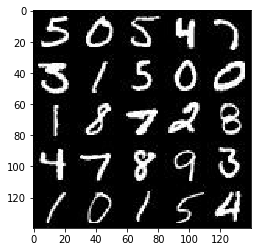

In [21]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

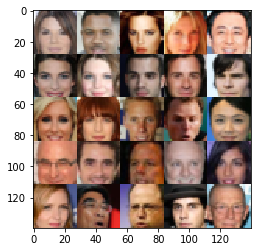

In [22]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [24]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)
    

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [25]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha=0.2
    
    # input layer is 28x 28 x3
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', activation=None)
        relu1 = tf.maximum(x1, alpha * x1)
        # here 14 x 14 x 64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', activation=None)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(bn2, alpha * bn2)
        # here 7 x 7 x 128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', activation=None)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # here 4 x 4 x 256
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [26]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', activation = None)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', activation = None)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', activation=None)
        # 28x28x3 now

        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [27]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [28]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [30]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    losses =  []
    steps = 0
    print_every = 10
    show_every = 100
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                batch_images*=2
                
                # sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict = {input_real: batch_images, input_z:batch_z , lr:learning_rate})
                _ = sess.run(g_opt, feed_dict = {input_real: batch_images,input_z:batch_z, lr:learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_real:batch_images, input_z:batch_z})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    print("Epoches:  {}/{}".format(epoch_i+1, epoch_count), 
                         "d_loss: {:.4f}".format(train_loss_d),
                         "g_loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoches:  1/2 d_loss: 0.4277 g_loss: 3.8774
Epoches:  1/2 d_loss: 0.3691 g_loss: 11.2305
Epoches:  1/2 d_loss: 0.3871 g_loss: 5.0393
Epoches:  1/2 d_loss: 0.3567 g_loss: 4.2111
Epoches:  1/2 d_loss: 0.5205 g_loss: 5.0646
Epoches:  1/2 d_loss: 0.6661 g_loss: 8.5000
Epoches:  1/2 d_loss: 1.5743 g_loss: 3.6688
Epoches:  1/2 d_loss: 0.8006 g_loss: 1.8739
Epoches:  1/2 d_loss: 1.1044 g_loss: 1.6889
Epoches:  1/2 d_loss: 1.0990 g_loss: 0.8038


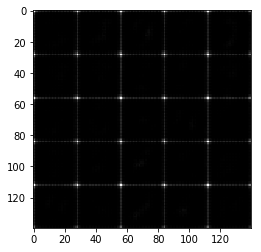

Epoches:  1/2 d_loss: 1.1332 g_loss: 0.8385
Epoches:  1/2 d_loss: 1.1071 g_loss: 0.9421
Epoches:  1/2 d_loss: 1.1967 g_loss: 0.8114
Epoches:  1/2 d_loss: 1.2556 g_loss: 1.0274
Epoches:  1/2 d_loss: 1.3649 g_loss: 1.4067
Epoches:  1/2 d_loss: 1.5433 g_loss: 2.5815
Epoches:  1/2 d_loss: 1.2675 g_loss: 1.1384
Epoches:  1/2 d_loss: 1.1519 g_loss: 0.9435
Epoches:  1/2 d_loss: 1.2992 g_loss: 1.5389
Epoches:  1/2 d_loss: 1.3149 g_loss: 0.8516


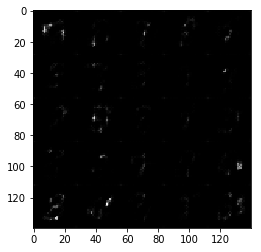

Epoches:  1/2 d_loss: 1.2290 g_loss: 0.9428
Epoches:  1/2 d_loss: 1.2305 g_loss: 1.3929
Epoches:  1/2 d_loss: 1.2431 g_loss: 0.8252
Epoches:  1/2 d_loss: 1.2191 g_loss: 1.4346
Epoches:  1/2 d_loss: 1.1115 g_loss: 0.8129
Epoches:  1/2 d_loss: 1.2449 g_loss: 1.1815
Epoches:  1/2 d_loss: 1.2983 g_loss: 0.6673
Epoches:  1/2 d_loss: 1.1853 g_loss: 1.1285
Epoches:  1/2 d_loss: 1.1506 g_loss: 1.0673
Epoches:  1/2 d_loss: 1.1839 g_loss: 0.7825


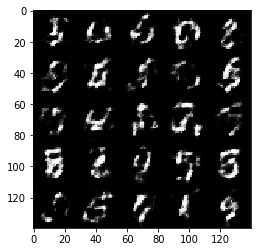

Epoches:  1/2 d_loss: 1.1514 g_loss: 0.9689
Epoches:  1/2 d_loss: 1.1196 g_loss: 0.9249
Epoches:  1/2 d_loss: 1.1244 g_loss: 0.9277
Epoches:  1/2 d_loss: 1.2392 g_loss: 0.7055
Epoches:  1/2 d_loss: 1.0524 g_loss: 0.9503
Epoches:  1/2 d_loss: 1.1767 g_loss: 0.7766
Epoches:  1/2 d_loss: 1.0446 g_loss: 1.0716
Epoches:  1/2 d_loss: 1.0637 g_loss: 0.8450
Epoches:  1/2 d_loss: 1.1379 g_loss: 1.5210
Epoches:  1/2 d_loss: 0.9820 g_loss: 1.0217


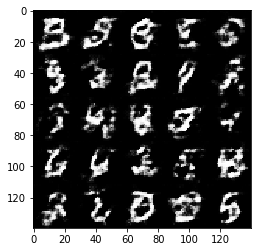

Epoches:  1/2 d_loss: 1.0828 g_loss: 0.8792
Epoches:  1/2 d_loss: 1.3547 g_loss: 0.5583
Epoches:  1/2 d_loss: 1.0633 g_loss: 0.8701
Epoches:  1/2 d_loss: 1.0643 g_loss: 1.2307
Epoches:  1/2 d_loss: 1.1081 g_loss: 1.6106
Epoches:  1/2 d_loss: 1.2021 g_loss: 0.7423
Epoches:  1/2 d_loss: 1.1722 g_loss: 1.3550
Epoches:  1/2 d_loss: 0.9936 g_loss: 1.1696
Epoches:  1/2 d_loss: 1.1512 g_loss: 1.0160
Epoches:  1/2 d_loss: 1.4310 g_loss: 0.4954


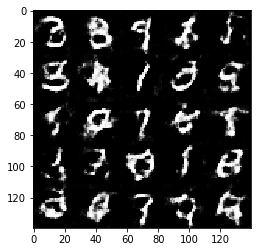

Epoches:  1/2 d_loss: 1.1800 g_loss: 1.0179
Epoches:  1/2 d_loss: 1.2309 g_loss: 0.6674
Epoches:  1/2 d_loss: 1.1757 g_loss: 0.7097
Epoches:  1/2 d_loss: 1.1144 g_loss: 0.9976
Epoches:  1/2 d_loss: 1.0606 g_loss: 1.1179
Epoches:  1/2 d_loss: 1.1544 g_loss: 0.9904
Epoches:  1/2 d_loss: 1.1234 g_loss: 0.9332
Epoches:  1/2 d_loss: 1.1885 g_loss: 0.7655
Epoches:  1/2 d_loss: 1.1381 g_loss: 1.0041
Epoches:  1/2 d_loss: 1.4577 g_loss: 0.5694


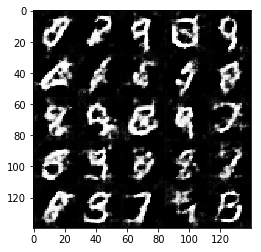

Epoches:  1/2 d_loss: 1.0565 g_loss: 0.9287
Epoches:  1/2 d_loss: 1.2436 g_loss: 1.1674
Epoches:  1/2 d_loss: 1.2029 g_loss: 0.7208
Epoches:  1/2 d_loss: 1.0883 g_loss: 1.1777
Epoches:  1/2 d_loss: 1.1462 g_loss: 1.1447
Epoches:  1/2 d_loss: 1.2045 g_loss: 0.7613
Epoches:  1/2 d_loss: 1.1549 g_loss: 1.1619
Epoches:  1/2 d_loss: 1.1630 g_loss: 0.8617
Epoches:  1/2 d_loss: 1.1611 g_loss: 1.0442
Epoches:  1/2 d_loss: 1.1932 g_loss: 1.0625


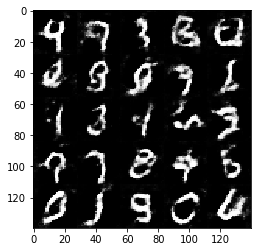

Epoches:  1/2 d_loss: 1.1933 g_loss: 0.7875
Epoches:  1/2 d_loss: 1.1531 g_loss: 1.1426
Epoches:  1/2 d_loss: 1.0531 g_loss: 0.9261
Epoches:  1/2 d_loss: 1.2445 g_loss: 0.6782
Epoches:  1/2 d_loss: 1.1334 g_loss: 1.0114
Epoches:  1/2 d_loss: 1.1615 g_loss: 0.9922
Epoches:  1/2 d_loss: 1.1304 g_loss: 1.0992
Epoches:  1/2 d_loss: 1.1816 g_loss: 0.8338
Epoches:  1/2 d_loss: 1.1874 g_loss: 0.7639
Epoches:  1/2 d_loss: 1.5447 g_loss: 0.4286


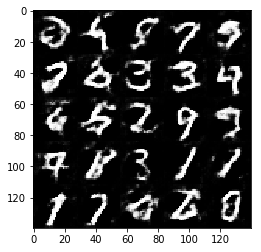

Epoches:  1/2 d_loss: 1.2502 g_loss: 0.8058
Epoches:  1/2 d_loss: 1.1454 g_loss: 0.8497
Epoches:  1/2 d_loss: 1.2550 g_loss: 0.8492
Epoches:  1/2 d_loss: 1.2113 g_loss: 0.7627
Epoches:  1/2 d_loss: 1.0932 g_loss: 1.1500
Epoches:  1/2 d_loss: 1.4625 g_loss: 0.4705
Epoches:  1/2 d_loss: 1.0840 g_loss: 1.0805
Epoches:  1/2 d_loss: 1.2412 g_loss: 0.8212
Epoches:  1/2 d_loss: 1.2898 g_loss: 1.3180
Epoches:  1/2 d_loss: 1.2592 g_loss: 0.7638


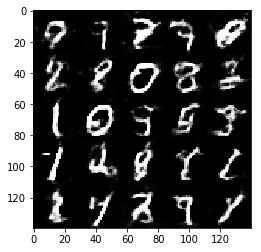

Epoches:  1/2 d_loss: 1.1677 g_loss: 0.8690
Epoches:  1/2 d_loss: 1.1580 g_loss: 0.8469
Epoches:  1/2 d_loss: 1.1504 g_loss: 0.8873
Epoches:  2/2 d_loss: 1.1251 g_loss: 0.9629
Epoches:  2/2 d_loss: 1.2464 g_loss: 0.7766
Epoches:  2/2 d_loss: 1.3648 g_loss: 1.5557
Epoches:  2/2 d_loss: 1.1961 g_loss: 0.7921
Epoches:  2/2 d_loss: 1.1889 g_loss: 1.0049
Epoches:  2/2 d_loss: 1.2022 g_loss: 1.2449
Epoches:  2/2 d_loss: 1.2042 g_loss: 0.8743


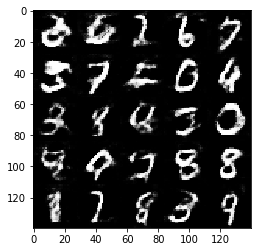

Epoches:  2/2 d_loss: 1.0799 g_loss: 1.0902
Epoches:  2/2 d_loss: 1.1996 g_loss: 0.9885
Epoches:  2/2 d_loss: 1.2469 g_loss: 0.6233
Epoches:  2/2 d_loss: 1.1590 g_loss: 1.1182
Epoches:  2/2 d_loss: 1.1712 g_loss: 0.8237
Epoches:  2/2 d_loss: 1.3422 g_loss: 0.5695
Epoches:  2/2 d_loss: 1.3133 g_loss: 0.6224
Epoches:  2/2 d_loss: 1.0962 g_loss: 1.9853
Epoches:  2/2 d_loss: 0.9848 g_loss: 0.9177
Epoches:  2/2 d_loss: 0.8878 g_loss: 1.9137


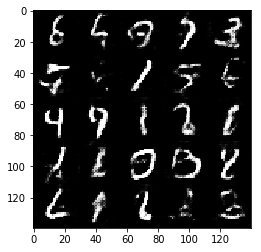

Epoches:  2/2 d_loss: 0.9470 g_loss: 1.3617
Epoches:  2/2 d_loss: 1.1910 g_loss: 0.6914
Epoches:  2/2 d_loss: 1.2679 g_loss: 0.6515
Epoches:  2/2 d_loss: 0.8926 g_loss: 2.0947
Epoches:  2/2 d_loss: 1.0418 g_loss: 0.9595
Epoches:  2/2 d_loss: 1.7442 g_loss: 0.3407
Epoches:  2/2 d_loss: 1.3430 g_loss: 0.5765
Epoches:  2/2 d_loss: 0.9418 g_loss: 1.2106
Epoches:  2/2 d_loss: 1.3712 g_loss: 0.5594
Epoches:  2/2 d_loss: 0.8762 g_loss: 1.5113


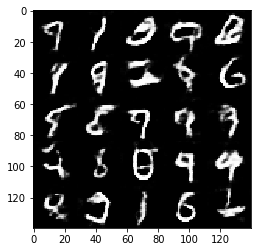

Epoches:  2/2 d_loss: 1.1993 g_loss: 1.3545
Epoches:  2/2 d_loss: 1.0010 g_loss: 1.4448
Epoches:  2/2 d_loss: 1.0586 g_loss: 1.0304
Epoches:  2/2 d_loss: 1.0465 g_loss: 1.6384
Epoches:  2/2 d_loss: 1.2348 g_loss: 0.6641
Epoches:  2/2 d_loss: 1.2166 g_loss: 0.6845
Epoches:  2/2 d_loss: 1.1217 g_loss: 1.1245
Epoches:  2/2 d_loss: 1.1688 g_loss: 0.8153
Epoches:  2/2 d_loss: 1.1805 g_loss: 0.8831
Epoches:  2/2 d_loss: 1.1240 g_loss: 0.9953


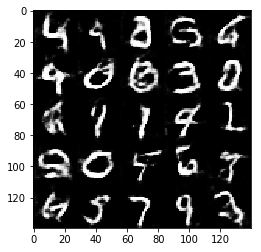

Epoches:  2/2 d_loss: 1.0946 g_loss: 1.0480
Epoches:  2/2 d_loss: 1.1355 g_loss: 0.9426
Epoches:  2/2 d_loss: 1.1704 g_loss: 0.8040
Epoches:  2/2 d_loss: 1.1579 g_loss: 0.9818
Epoches:  2/2 d_loss: 1.0935 g_loss: 1.2868
Epoches:  2/2 d_loss: 1.1334 g_loss: 1.1008
Epoches:  2/2 d_loss: 1.2408 g_loss: 0.7730
Epoches:  2/2 d_loss: 1.1320 g_loss: 0.9493
Epoches:  2/2 d_loss: 1.0701 g_loss: 1.1525
Epoches:  2/2 d_loss: 1.3465 g_loss: 0.5363


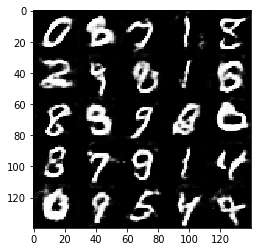

Epoches:  2/2 d_loss: 1.1530 g_loss: 0.9408
Epoches:  2/2 d_loss: 1.1770 g_loss: 0.9408
Epoches:  2/2 d_loss: 1.1990 g_loss: 1.0992
Epoches:  2/2 d_loss: 1.2398 g_loss: 0.7697
Epoches:  2/2 d_loss: 1.1975 g_loss: 1.5089
Epoches:  2/2 d_loss: 1.0404 g_loss: 1.1671
Epoches:  2/2 d_loss: 1.1275 g_loss: 0.8905
Epoches:  2/2 d_loss: 1.1547 g_loss: 1.1172
Epoches:  2/2 d_loss: 1.2509 g_loss: 0.7508
Epoches:  2/2 d_loss: 1.2367 g_loss: 1.0499


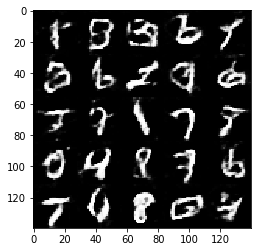

Epoches:  2/2 d_loss: 1.0709 g_loss: 1.1893
Epoches:  2/2 d_loss: 1.2610 g_loss: 0.6870
Epoches:  2/2 d_loss: 1.1687 g_loss: 0.7525
Epoches:  2/2 d_loss: 1.2106 g_loss: 0.6571
Epoches:  2/2 d_loss: 1.1188 g_loss: 1.0101
Epoches:  2/2 d_loss: 1.1736 g_loss: 1.1890
Epoches:  2/2 d_loss: 1.1200 g_loss: 1.1533
Epoches:  2/2 d_loss: 1.0985 g_loss: 0.9643
Epoches:  2/2 d_loss: 1.1568 g_loss: 0.7859
Epoches:  2/2 d_loss: 1.1015 g_loss: 1.1077


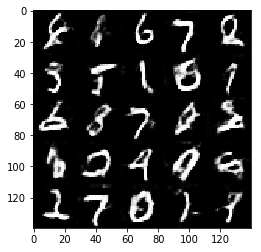

Epoches:  2/2 d_loss: 1.2239 g_loss: 0.9057
Epoches:  2/2 d_loss: 1.1719 g_loss: 1.0661
Epoches:  2/2 d_loss: 1.1026 g_loss: 0.8018
Epoches:  2/2 d_loss: 1.1979 g_loss: 0.9121
Epoches:  2/2 d_loss: 1.1268 g_loss: 0.9436
Epoches:  2/2 d_loss: 1.1910 g_loss: 0.7179
Epoches:  2/2 d_loss: 1.2120 g_loss: 0.6821
Epoches:  2/2 d_loss: 1.1284 g_loss: 0.9883
Epoches:  2/2 d_loss: 1.0983 g_loss: 0.8182
Epoches:  2/2 d_loss: 1.1327 g_loss: 1.2096


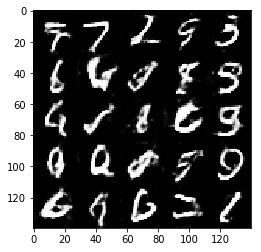

Epoches:  2/2 d_loss: 1.1909 g_loss: 1.2423
Epoches:  2/2 d_loss: 1.2049 g_loss: 0.8848
Epoches:  2/2 d_loss: 1.1646 g_loss: 0.8161
Epoches:  2/2 d_loss: 1.1440 g_loss: 0.8783
Epoches:  2/2 d_loss: 1.0908 g_loss: 1.3283
Epoches:  2/2 d_loss: 1.0980 g_loss: 1.2698
Epoches:  2/2 d_loss: 1.1863 g_loss: 0.8668
Epoches:  2/2 d_loss: 1.2834 g_loss: 0.6632
Epoches:  2/2 d_loss: 1.1767 g_loss: 0.8767
Epoches:  2/2 d_loss: 1.1061 g_loss: 1.1543


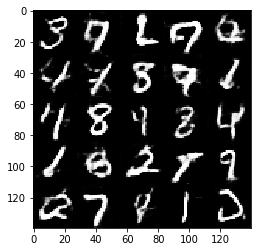

Epoches:  2/2 d_loss: 1.2717 g_loss: 0.6558
Epoches:  2/2 d_loss: 1.1419 g_loss: 0.9690
Epoches:  2/2 d_loss: 1.2217 g_loss: 0.7857
Epoches:  2/2 d_loss: 1.0948 g_loss: 1.0126
Epoches:  2/2 d_loss: 1.1956 g_loss: 0.7607
Epoches:  2/2 d_loss: 1.1709 g_loss: 1.3701
Epoches:  2/2 d_loss: 1.1390 g_loss: 1.3790


In [31]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoches:  1/1 d_loss: 0.5460 g_loss: 2.8178
Epoches:  1/1 d_loss: 0.4150 g_loss: 3.6952
Epoches:  1/1 d_loss: 0.3557 g_loss: 10.0439
Epoches:  1/1 d_loss: 0.5207 g_loss: 3.2071
Epoches:  1/1 d_loss: 0.3545 g_loss: 5.4049
Epoches:  1/1 d_loss: 0.3774 g_loss: 3.8328
Epoches:  1/1 d_loss: 1.7882 g_loss: 6.0207
Epoches:  1/1 d_loss: 0.5905 g_loss: 3.3229
Epoches:  1/1 d_loss: 1.9303 g_loss: 0.3513
Epoches:  1/1 d_loss: 0.8121 g_loss: 1.2357


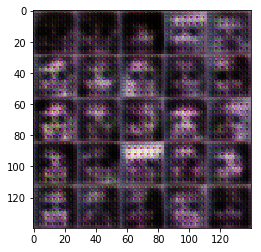

Epoches:  1/1 d_loss: 0.7548 g_loss: 1.4170
Epoches:  1/1 d_loss: 1.4526 g_loss: 0.5125
Epoches:  1/1 d_loss: 1.0538 g_loss: 6.9286
Epoches:  1/1 d_loss: 0.7766 g_loss: 1.1910
Epoches:  1/1 d_loss: 0.5785 g_loss: 1.9767
Epoches:  1/1 d_loss: 1.1518 g_loss: 5.5761
Epoches:  1/1 d_loss: 0.6917 g_loss: 1.5356
Epoches:  1/1 d_loss: 0.8058 g_loss: 1.3018
Epoches:  1/1 d_loss: 0.6641 g_loss: 2.1427
Epoches:  1/1 d_loss: 1.1735 g_loss: 1.0242


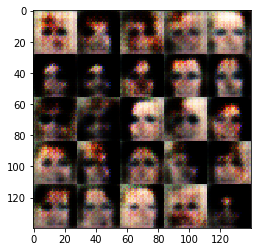

Epoches:  1/1 d_loss: 1.2758 g_loss: 3.4332
Epoches:  1/1 d_loss: 0.8704 g_loss: 1.4944
Epoches:  1/1 d_loss: 1.0895 g_loss: 1.9845
Epoches:  1/1 d_loss: 0.9585 g_loss: 0.9469
Epoches:  1/1 d_loss: 0.9988 g_loss: 1.1645
Epoches:  1/1 d_loss: 0.9866 g_loss: 0.8891
Epoches:  1/1 d_loss: 0.9799 g_loss: 1.0291
Epoches:  1/1 d_loss: 2.4217 g_loss: 3.4700
Epoches:  1/1 d_loss: 1.4691 g_loss: 0.5015
Epoches:  1/1 d_loss: 2.1891 g_loss: 0.2014


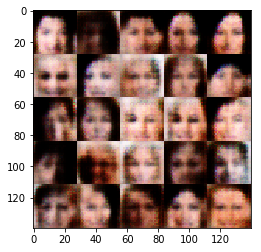

Epoches:  1/1 d_loss: 1.0960 g_loss: 1.2032
Epoches:  1/1 d_loss: 2.8192 g_loss: 6.3020
Epoches:  1/1 d_loss: 1.3829 g_loss: 0.8852
Epoches:  1/1 d_loss: 1.4106 g_loss: 0.7372
Epoches:  1/1 d_loss: 1.1288 g_loss: 0.7086
Epoches:  1/1 d_loss: 1.9304 g_loss: 0.2823
Epoches:  1/1 d_loss: 1.1012 g_loss: 0.8425
Epoches:  1/1 d_loss: 1.4877 g_loss: 0.4382
Epoches:  1/1 d_loss: 1.4886 g_loss: 0.5598
Epoches:  1/1 d_loss: 0.9257 g_loss: 0.9501


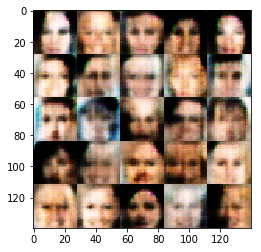

Epoches:  1/1 d_loss: 0.9792 g_loss: 1.8259
Epoches:  1/1 d_loss: 0.6490 g_loss: 1.6750
Epoches:  1/1 d_loss: 1.2403 g_loss: 0.8646
Epoches:  1/1 d_loss: 1.3222 g_loss: 2.3126
Epoches:  1/1 d_loss: 0.8019 g_loss: 1.8302
Epoches:  1/1 d_loss: 0.9419 g_loss: 1.0080
Epoches:  1/1 d_loss: 1.3370 g_loss: 0.7040
Epoches:  1/1 d_loss: 1.1298 g_loss: 0.9517
Epoches:  1/1 d_loss: 1.3380 g_loss: 0.6267
Epoches:  1/1 d_loss: 1.3104 g_loss: 0.6931


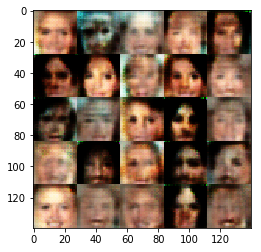

Epoches:  1/1 d_loss: 0.9101 g_loss: 3.9653
Epoches:  1/1 d_loss: 1.3642 g_loss: 0.5106
Epoches:  1/1 d_loss: 1.3177 g_loss: 1.2195
Epoches:  1/1 d_loss: 2.2012 g_loss: 0.1837
Epoches:  1/1 d_loss: 1.5146 g_loss: 0.5640
Epoches:  1/1 d_loss: 1.2076 g_loss: 1.1164
Epoches:  1/1 d_loss: 0.8922 g_loss: 1.3100
Epoches:  1/1 d_loss: 0.8324 g_loss: 1.4954
Epoches:  1/1 d_loss: 1.6939 g_loss: 0.3615
Epoches:  1/1 d_loss: 1.0635 g_loss: 1.1008


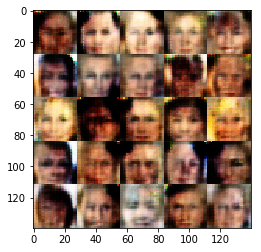

Epoches:  1/1 d_loss: 1.0726 g_loss: 0.9596
Epoches:  1/1 d_loss: 1.3849 g_loss: 1.1203
Epoches:  1/1 d_loss: 1.3012 g_loss: 0.7707
Epoches:  1/1 d_loss: 1.3949 g_loss: 0.5702
Epoches:  1/1 d_loss: 2.1910 g_loss: 0.1923
Epoches:  1/1 d_loss: 1.0087 g_loss: 1.1975
Epoches:  1/1 d_loss: 1.2903 g_loss: 0.5967
Epoches:  1/1 d_loss: 1.6169 g_loss: 0.4262
Epoches:  1/1 d_loss: 1.0980 g_loss: 0.8846
Epoches:  1/1 d_loss: 0.8519 g_loss: 1.5389


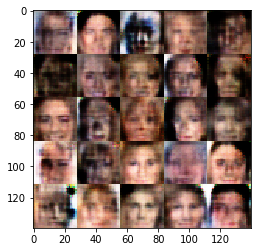

Epoches:  1/1 d_loss: 1.1400 g_loss: 2.2920
Epoches:  1/1 d_loss: 1.2385 g_loss: 0.8846
Epoches:  1/1 d_loss: 0.6009 g_loss: 2.0118
Epoches:  1/1 d_loss: 1.3122 g_loss: 0.9563
Epoches:  1/1 d_loss: 0.6190 g_loss: 2.7287
Epoches:  1/1 d_loss: 1.0579 g_loss: 0.8864
Epoches:  1/1 d_loss: 1.3420 g_loss: 0.9962
Epoches:  1/1 d_loss: 1.1372 g_loss: 0.7988
Epoches:  1/1 d_loss: 1.1222 g_loss: 0.9185
Epoches:  1/1 d_loss: 1.1405 g_loss: 1.3310


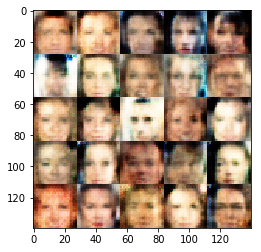

Epoches:  1/1 d_loss: 0.9353 g_loss: 1.1125
Epoches:  1/1 d_loss: 1.5429 g_loss: 0.4388
Epoches:  1/1 d_loss: 0.7644 g_loss: 1.7808
Epoches:  1/1 d_loss: 1.4098 g_loss: 0.7786
Epoches:  1/1 d_loss: 1.0082 g_loss: 1.3234
Epoches:  1/1 d_loss: 1.3516 g_loss: 0.7218
Epoches:  1/1 d_loss: 1.0948 g_loss: 0.7755
Epoches:  1/1 d_loss: 1.1979 g_loss: 1.6913
Epoches:  1/1 d_loss: 1.5710 g_loss: 2.3289
Epoches:  1/1 d_loss: 1.4179 g_loss: 0.4853


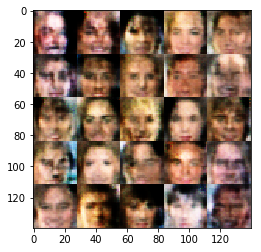

Epoches:  1/1 d_loss: 1.0882 g_loss: 1.4993
Epoches:  1/1 d_loss: 1.1515 g_loss: 1.0442
Epoches:  1/1 d_loss: 1.1938 g_loss: 0.6720
Epoches:  1/1 d_loss: 0.7520 g_loss: 1.4063
Epoches:  1/1 d_loss: 1.2540 g_loss: 0.7673
Epoches:  1/1 d_loss: 1.2742 g_loss: 0.8093
Epoches:  1/1 d_loss: 1.7510 g_loss: 1.9601
Epoches:  1/1 d_loss: 1.0895 g_loss: 1.1539
Epoches:  1/1 d_loss: 1.5853 g_loss: 0.3771
Epoches:  1/1 d_loss: 1.2134 g_loss: 0.6206


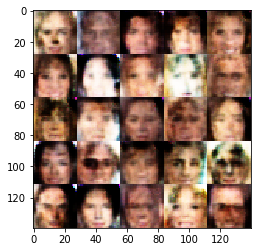

Epoches:  1/1 d_loss: 1.2039 g_loss: 1.0380
Epoches:  1/1 d_loss: 1.1064 g_loss: 1.6065
Epoches:  1/1 d_loss: 1.1532 g_loss: 0.7660
Epoches:  1/1 d_loss: 0.9193 g_loss: 1.6100
Epoches:  1/1 d_loss: 1.2002 g_loss: 0.6789
Epoches:  1/1 d_loss: 1.0844 g_loss: 1.5567
Epoches:  1/1 d_loss: 0.9545 g_loss: 1.0966
Epoches:  1/1 d_loss: 0.9329 g_loss: 0.9369
Epoches:  1/1 d_loss: 1.2674 g_loss: 1.2344
Epoches:  1/1 d_loss: 1.1528 g_loss: 0.6889


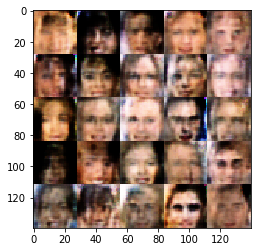

Epoches:  1/1 d_loss: 1.0290 g_loss: 1.2816
Epoches:  1/1 d_loss: 0.8552 g_loss: 1.1900
Epoches:  1/1 d_loss: 1.2705 g_loss: 0.5811
Epoches:  1/1 d_loss: 1.3066 g_loss: 0.5765
Epoches:  1/1 d_loss: 0.7371 g_loss: 2.7168
Epoches:  1/1 d_loss: 1.1036 g_loss: 0.7840
Epoches:  1/1 d_loss: 1.4802 g_loss: 3.9180
Epoches:  1/1 d_loss: 1.1100 g_loss: 0.7128
Epoches:  1/1 d_loss: 1.1885 g_loss: 1.5371
Epoches:  1/1 d_loss: 1.3782 g_loss: 0.6925


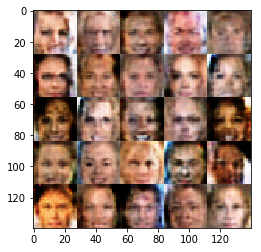

Epoches:  1/1 d_loss: 1.3247 g_loss: 0.8747
Epoches:  1/1 d_loss: 1.2603 g_loss: 0.7813
Epoches:  1/1 d_loss: 1.0204 g_loss: 1.1703
Epoches:  1/1 d_loss: 1.5199 g_loss: 0.4866
Epoches:  1/1 d_loss: 0.6827 g_loss: 1.6831
Epoches:  1/1 d_loss: 0.9040 g_loss: 1.0302
Epoches:  1/1 d_loss: 0.8772 g_loss: 1.4119
Epoches:  1/1 d_loss: 0.9081 g_loss: 1.0696
Epoches:  1/1 d_loss: 1.0314 g_loss: 1.7221
Epoches:  1/1 d_loss: 1.3495 g_loss: 1.4230


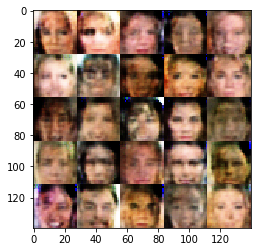

Epoches:  1/1 d_loss: 1.0152 g_loss: 1.0713
Epoches:  1/1 d_loss: 0.8521 g_loss: 1.1619
Epoches:  1/1 d_loss: 1.6049 g_loss: 1.7634
Epoches:  1/1 d_loss: 0.7497 g_loss: 3.1856
Epoches:  1/1 d_loss: 0.8571 g_loss: 1.2869
Epoches:  1/1 d_loss: 1.3469 g_loss: 0.5339
Epoches:  1/1 d_loss: 2.0780 g_loss: 0.2193
Epoches:  1/1 d_loss: 0.9007 g_loss: 1.2996
Epoches:  1/1 d_loss: 1.2012 g_loss: 0.7331
Epoches:  1/1 d_loss: 1.6373 g_loss: 0.3548


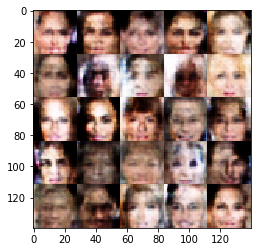

Epoches:  1/1 d_loss: 1.1353 g_loss: 1.8505
Epoches:  1/1 d_loss: 0.8588 g_loss: 1.8644
Epoches:  1/1 d_loss: 1.0862 g_loss: 0.7565
Epoches:  1/1 d_loss: 1.2439 g_loss: 0.9058
Epoches:  1/1 d_loss: 1.6925 g_loss: 0.3521
Epoches:  1/1 d_loss: 1.1097 g_loss: 0.7654
Epoches:  1/1 d_loss: 1.0627 g_loss: 0.7574
Epoches:  1/1 d_loss: 1.0445 g_loss: 0.8306
Epoches:  1/1 d_loss: 1.1485 g_loss: 0.9009
Epoches:  1/1 d_loss: 1.1977 g_loss: 1.1382


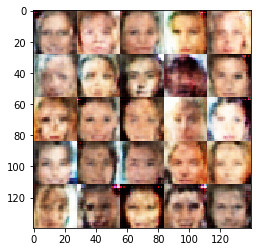

Epoches:  1/1 d_loss: 1.2937 g_loss: 0.8559
Epoches:  1/1 d_loss: 1.2714 g_loss: 0.8776
Epoches:  1/1 d_loss: 0.8174 g_loss: 1.4804
Epoches:  1/1 d_loss: 1.2115 g_loss: 1.8368
Epoches:  1/1 d_loss: 1.3821 g_loss: 0.5875
Epoches:  1/1 d_loss: 1.0781 g_loss: 2.4540
Epoches:  1/1 d_loss: 1.5313 g_loss: 0.3843
Epoches:  1/1 d_loss: 0.8979 g_loss: 1.7468
Epoches:  1/1 d_loss: 1.3611 g_loss: 0.6329
Epoches:  1/1 d_loss: 0.9679 g_loss: 1.3350


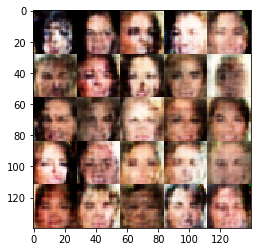

Epoches:  1/1 d_loss: 1.2361 g_loss: 1.2950
Epoches:  1/1 d_loss: 1.7025 g_loss: 2.4815
Epoches:  1/1 d_loss: 0.6012 g_loss: 2.2331
Epoches:  1/1 d_loss: 1.1449 g_loss: 0.7956
Epoches:  1/1 d_loss: 1.3033 g_loss: 0.7659
Epoches:  1/1 d_loss: 1.1854 g_loss: 0.8666
Epoches:  1/1 d_loss: 0.9426 g_loss: 1.3748
Epoches:  1/1 d_loss: 0.8888 g_loss: 1.0555
Epoches:  1/1 d_loss: 0.8160 g_loss: 1.3650
Epoches:  1/1 d_loss: 1.0993 g_loss: 0.7612


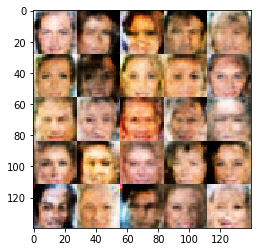

Epoches:  1/1 d_loss: 0.9371 g_loss: 1.0284
Epoches:  1/1 d_loss: 0.8923 g_loss: 2.0816
Epoches:  1/1 d_loss: 1.2916 g_loss: 0.6489
Epoches:  1/1 d_loss: 0.8550 g_loss: 1.5753
Epoches:  1/1 d_loss: 0.9917 g_loss: 1.0478
Epoches:  1/1 d_loss: 1.2685 g_loss: 1.0190
Epoches:  1/1 d_loss: 1.0151 g_loss: 1.0130
Epoches:  1/1 d_loss: 0.9488 g_loss: 1.3648
Epoches:  1/1 d_loss: 1.3536 g_loss: 1.3597
Epoches:  1/1 d_loss: 1.0426 g_loss: 0.8095


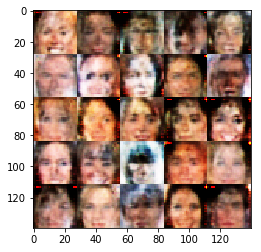

Epoches:  1/1 d_loss: 1.1158 g_loss: 0.8311
Epoches:  1/1 d_loss: 1.4525 g_loss: 2.1392
Epoches:  1/1 d_loss: 1.0972 g_loss: 1.3930
Epoches:  1/1 d_loss: 1.1944 g_loss: 0.6685
Epoches:  1/1 d_loss: 1.0276 g_loss: 0.9697
Epoches:  1/1 d_loss: 0.5311 g_loss: 2.1576
Epoches:  1/1 d_loss: 1.8462 g_loss: 1.6293
Epoches:  1/1 d_loss: 0.9291 g_loss: 1.0930
Epoches:  1/1 d_loss: 1.2728 g_loss: 0.8750
Epoches:  1/1 d_loss: 1.0514 g_loss: 0.8064


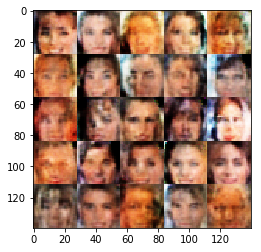

Epoches:  1/1 d_loss: 1.2858 g_loss: 0.9643
Epoches:  1/1 d_loss: 1.0811 g_loss: 0.8904
Epoches:  1/1 d_loss: 0.9044 g_loss: 1.1751
Epoches:  1/1 d_loss: 0.8169 g_loss: 1.5141
Epoches:  1/1 d_loss: 1.0509 g_loss: 1.2789
Epoches:  1/1 d_loss: 1.0868 g_loss: 0.7265
Epoches:  1/1 d_loss: 1.2661 g_loss: 1.5358
Epoches:  1/1 d_loss: 1.3370 g_loss: 0.5177
Epoches:  1/1 d_loss: 0.6469 g_loss: 2.0295
Epoches:  1/1 d_loss: 1.5697 g_loss: 0.4302


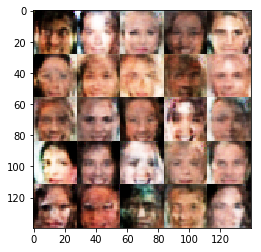

Epoches:  1/1 d_loss: 1.4124 g_loss: 0.7165
Epoches:  1/1 d_loss: 1.2824 g_loss: 2.3622
Epoches:  1/1 d_loss: 1.1250 g_loss: 0.9225
Epoches:  1/1 d_loss: 1.0224 g_loss: 0.9194
Epoches:  1/1 d_loss: 0.9683 g_loss: 1.1803
Epoches:  1/1 d_loss: 1.2665 g_loss: 2.4442
Epoches:  1/1 d_loss: 1.4207 g_loss: 0.4422
Epoches:  1/1 d_loss: 1.5203 g_loss: 0.4700
Epoches:  1/1 d_loss: 1.2354 g_loss: 1.0630
Epoches:  1/1 d_loss: 1.1116 g_loss: 1.9478


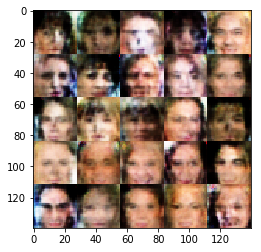

Epoches:  1/1 d_loss: 1.4224 g_loss: 1.6887
Epoches:  1/1 d_loss: 1.0021 g_loss: 1.0883
Epoches:  1/1 d_loss: 1.1540 g_loss: 1.0955
Epoches:  1/1 d_loss: 1.0588 g_loss: 0.9265
Epoches:  1/1 d_loss: 0.8640 g_loss: 1.7471
Epoches:  1/1 d_loss: 1.3426 g_loss: 0.5684
Epoches:  1/1 d_loss: 1.6649 g_loss: 0.3689
Epoches:  1/1 d_loss: 1.0220 g_loss: 1.2120
Epoches:  1/1 d_loss: 1.0413 g_loss: 1.0141
Epoches:  1/1 d_loss: 1.0121 g_loss: 0.8052


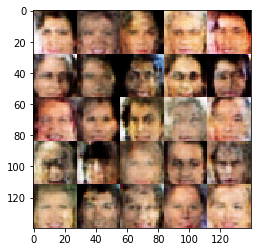

Epoches:  1/1 d_loss: 1.1691 g_loss: 0.6785
Epoches:  1/1 d_loss: 1.1241 g_loss: 0.8131
Epoches:  1/1 d_loss: 1.0529 g_loss: 0.8983
Epoches:  1/1 d_loss: 1.3950 g_loss: 0.5124
Epoches:  1/1 d_loss: 0.9677 g_loss: 1.1009
Epoches:  1/1 d_loss: 0.8743 g_loss: 1.2693
Epoches:  1/1 d_loss: 0.9985 g_loss: 0.8988
Epoches:  1/1 d_loss: 0.9047 g_loss: 1.0294
Epoches:  1/1 d_loss: 0.9757 g_loss: 1.0511
Epoches:  1/1 d_loss: 1.4736 g_loss: 0.4971


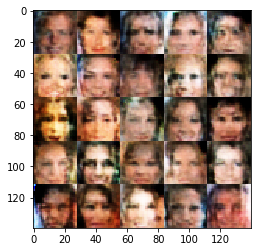

Epoches:  1/1 d_loss: 0.5826 g_loss: 3.1580
Epoches:  1/1 d_loss: 0.9619 g_loss: 1.2133
Epoches:  1/1 d_loss: 0.9692 g_loss: 0.9139
Epoches:  1/1 d_loss: 1.2378 g_loss: 0.8786
Epoches:  1/1 d_loss: 0.6365 g_loss: 2.4655
Epoches:  1/1 d_loss: 1.2707 g_loss: 0.8005
Epoches:  1/1 d_loss: 0.9149 g_loss: 1.3045
Epoches:  1/1 d_loss: 1.1603 g_loss: 0.8065
Epoches:  1/1 d_loss: 1.0647 g_loss: 0.9187
Epoches:  1/1 d_loss: 0.8227 g_loss: 1.2415


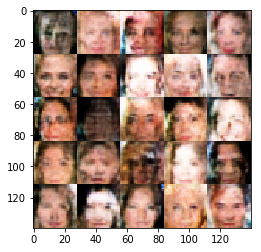

Epoches:  1/1 d_loss: 1.1857 g_loss: 0.7747
Epoches:  1/1 d_loss: 1.0252 g_loss: 0.9998
Epoches:  1/1 d_loss: 0.9491 g_loss: 0.9460
Epoches:  1/1 d_loss: 1.4747 g_loss: 1.3925
Epoches:  1/1 d_loss: 1.3934 g_loss: 0.5010
Epoches:  1/1 d_loss: 1.2611 g_loss: 0.9941
Epoches:  1/1 d_loss: 1.2516 g_loss: 0.7643
Epoches:  1/1 d_loss: 1.0571 g_loss: 0.7873
Epoches:  1/1 d_loss: 1.1906 g_loss: 0.8655
Epoches:  1/1 d_loss: 1.1677 g_loss: 1.0055


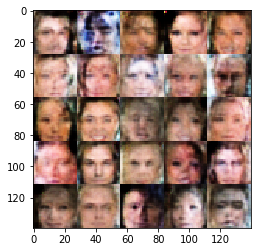

Epoches:  1/1 d_loss: 0.6439 g_loss: 1.7682
Epoches:  1/1 d_loss: 0.4691 g_loss: 3.1485
Epoches:  1/1 d_loss: 1.0971 g_loss: 1.4437
Epoches:  1/1 d_loss: 0.8218 g_loss: 1.2097
Epoches:  1/1 d_loss: 1.2406 g_loss: 0.7693
Epoches:  1/1 d_loss: 1.0085 g_loss: 1.0671
Epoches:  1/1 d_loss: 1.0732 g_loss: 1.7412
Epoches:  1/1 d_loss: 1.1011 g_loss: 0.9452
Epoches:  1/1 d_loss: 1.3750 g_loss: 0.8617
Epoches:  1/1 d_loss: 1.2568 g_loss: 0.6625


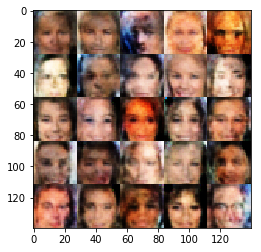

Epoches:  1/1 d_loss: 1.3880 g_loss: 1.4185
Epoches:  1/1 d_loss: 1.2871 g_loss: 0.5824
Epoches:  1/1 d_loss: 1.3323 g_loss: 1.6521
Epoches:  1/1 d_loss: 1.2800 g_loss: 0.5826
Epoches:  1/1 d_loss: 1.1542 g_loss: 1.0788
Epoches:  1/1 d_loss: 0.7488 g_loss: 1.4019
Epoches:  1/1 d_loss: 1.1333 g_loss: 1.0259
Epoches:  1/1 d_loss: 1.1465 g_loss: 0.9320
Epoches:  1/1 d_loss: 0.8847 g_loss: 1.5313
Epoches:  1/1 d_loss: 1.3715 g_loss: 0.5479


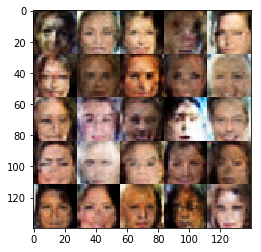

Epoches:  1/1 d_loss: 1.1972 g_loss: 0.7457
Epoches:  1/1 d_loss: 1.1272 g_loss: 1.0775
Epoches:  1/1 d_loss: 0.7596 g_loss: 1.3938
Epoches:  1/1 d_loss: 1.2434 g_loss: 0.6808
Epoches:  1/1 d_loss: 1.0125 g_loss: 0.9019
Epoches:  1/1 d_loss: 1.0473 g_loss: 1.2740
Epoches:  1/1 d_loss: 1.6177 g_loss: 0.3895
Epoches:  1/1 d_loss: 1.1300 g_loss: 1.0906
Epoches:  1/1 d_loss: 1.0603 g_loss: 0.8976
Epoches:  1/1 d_loss: 1.6113 g_loss: 1.8314


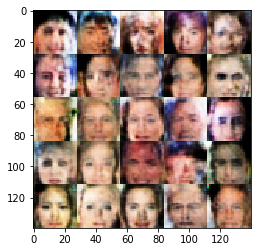

Epoches:  1/1 d_loss: 1.0919 g_loss: 0.9237
Epoches:  1/1 d_loss: 0.7773 g_loss: 1.5255
Epoches:  1/1 d_loss: 1.3532 g_loss: 0.4922
Epoches:  1/1 d_loss: 1.1333 g_loss: 1.1216
Epoches:  1/1 d_loss: 0.9642 g_loss: 1.0485
Epoches:  1/1 d_loss: 1.1913 g_loss: 0.8105
Epoches:  1/1 d_loss: 1.1238 g_loss: 1.3440
Epoches:  1/1 d_loss: 0.9323 g_loss: 1.2130
Epoches:  1/1 d_loss: 0.8336 g_loss: 2.6690
Epoches:  1/1 d_loss: 1.1441 g_loss: 1.8850


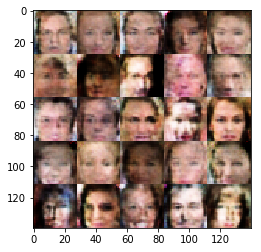

Epoches:  1/1 d_loss: 1.4562 g_loss: 0.4669
Epoches:  1/1 d_loss: 1.1145 g_loss: 1.5770
Epoches:  1/1 d_loss: 1.1546 g_loss: 0.7253
Epoches:  1/1 d_loss: 0.8962 g_loss: 1.1125
Epoches:  1/1 d_loss: 1.7113 g_loss: 2.6923
Epoches:  1/1 d_loss: 0.8605 g_loss: 1.5656
Epoches:  1/1 d_loss: 1.3042 g_loss: 0.8611
Epoches:  1/1 d_loss: 1.3366 g_loss: 0.8680
Epoches:  1/1 d_loss: 0.8861 g_loss: 1.6782
Epoches:  1/1 d_loss: 1.2490 g_loss: 0.8458


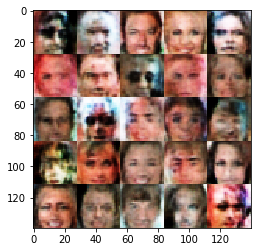

Epoches:  1/1 d_loss: 1.1985 g_loss: 0.6695
Epoches:  1/1 d_loss: 1.2155 g_loss: 0.8928
Epoches:  1/1 d_loss: 1.3619 g_loss: 0.8191
Epoches:  1/1 d_loss: 1.0310 g_loss: 0.9263
Epoches:  1/1 d_loss: 1.0663 g_loss: 1.5079
Epoches:  1/1 d_loss: 1.0003 g_loss: 1.1139
Epoches:  1/1 d_loss: 1.3645 g_loss: 0.5766
Epoches:  1/1 d_loss: 1.3922 g_loss: 0.4970
Epoches:  1/1 d_loss: 0.8947 g_loss: 1.0604
Epoches:  1/1 d_loss: 1.3348 g_loss: 0.5608


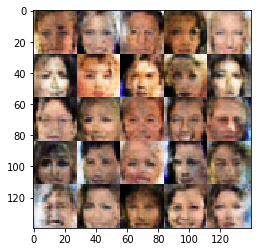

Epoches:  1/1 d_loss: 0.9607 g_loss: 0.9483
Epoches:  1/1 d_loss: 1.2607 g_loss: 0.8082
Epoches:  1/1 d_loss: 0.8755 g_loss: 1.3602
Epoches:  1/1 d_loss: 0.7122 g_loss: 1.7590
Epoches:  1/1 d_loss: 1.4060 g_loss: 2.7915
Epoches:  1/1 d_loss: 0.6490 g_loss: 1.4631
Epoches:  1/1 d_loss: 0.7048 g_loss: 2.0337
Epoches:  1/1 d_loss: 0.5963 g_loss: 1.6759
Epoches:  1/1 d_loss: 0.4574 g_loss: 3.1447
Epoches:  1/1 d_loss: 0.6793 g_loss: 1.3851


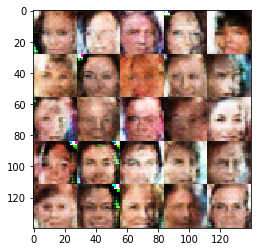

Epoches:  1/1 d_loss: 0.5010 g_loss: 3.1074
Epoches:  1/1 d_loss: 0.6633 g_loss: 1.5856
Epoches:  1/1 d_loss: 0.6085 g_loss: 1.5804
Epoches:  1/1 d_loss: 1.4901 g_loss: 0.4376
Epoches:  1/1 d_loss: 0.7582 g_loss: 1.2669
Epoches:  1/1 d_loss: 0.8175 g_loss: 1.1097
Epoches:  1/1 d_loss: 0.9900 g_loss: 0.8750
Epoches:  1/1 d_loss: 0.9498 g_loss: 1.6385
Epoches:  1/1 d_loss: 0.9418 g_loss: 1.5065
Epoches:  1/1 d_loss: 0.9636 g_loss: 1.9815


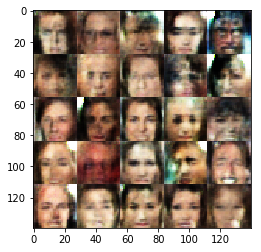

Epoches:  1/1 d_loss: 0.8002 g_loss: 1.2384
Epoches:  1/1 d_loss: 0.6386 g_loss: 1.5306
Epoches:  1/1 d_loss: 0.8914 g_loss: 1.0126
Epoches:  1/1 d_loss: 0.8801 g_loss: 1.0620
Epoches:  1/1 d_loss: 0.8636 g_loss: 0.9821
Epoches:  1/1 d_loss: 0.9458 g_loss: 1.0635
Epoches:  1/1 d_loss: 0.8280 g_loss: 1.8114
Epoches:  1/1 d_loss: 1.1444 g_loss: 0.7947
Epoches:  1/1 d_loss: 1.7841 g_loss: 0.3814
Epoches:  1/1 d_loss: 1.0015 g_loss: 1.7930


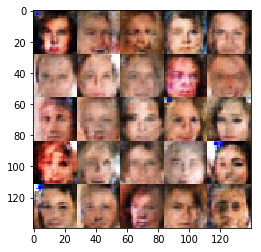

Epoches:  1/1 d_loss: 0.9001 g_loss: 1.7270
Epoches:  1/1 d_loss: 1.4914 g_loss: 0.4445
Epoches:  1/1 d_loss: 0.8682 g_loss: 1.1022
Epoches:  1/1 d_loss: 2.4046 g_loss: 2.6829
Epoches:  1/1 d_loss: 1.3153 g_loss: 1.3410
Epoches:  1/1 d_loss: 1.1429 g_loss: 0.8663
Epoches:  1/1 d_loss: 0.4380 g_loss: 3.3155
Epoches:  1/1 d_loss: 0.9650 g_loss: 1.0706
Epoches:  1/1 d_loss: 0.7644 g_loss: 1.4066
Epoches:  1/1 d_loss: 0.3565 g_loss: 5.3365


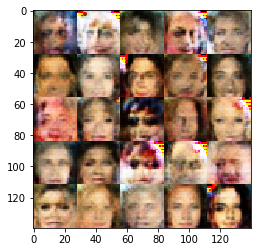

Epoches:  1/1 d_loss: 0.4359 g_loss: 3.3643
Epoches:  1/1 d_loss: 0.3724 g_loss: 4.0163
Epoches:  1/1 d_loss: 0.4658 g_loss: 2.7881
Epoches:  1/1 d_loss: 0.6356 g_loss: 1.8008
Epoches:  1/1 d_loss: 0.3817 g_loss: 3.7138
Epoches:  1/1 d_loss: 0.4679 g_loss: 2.6105
Epoches:  1/1 d_loss: 0.3960 g_loss: 3.1768
Epoches:  1/1 d_loss: 0.4021 g_loss: 3.2906
Epoches:  1/1 d_loss: 0.3642 g_loss: 3.8904
Epoches:  1/1 d_loss: 0.3809 g_loss: 4.6410


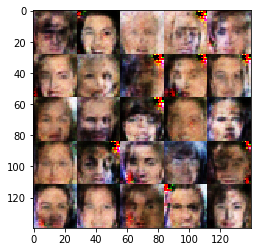

Epoches:  1/1 d_loss: 0.4591 g_loss: 2.5945
Epoches:  1/1 d_loss: 0.4915 g_loss: 2.1338
Epoches:  1/1 d_loss: 0.3409 g_loss: 5.5789
Epoches:  1/1 d_loss: 3.0900 g_loss: 3.5964
Epoches:  1/1 d_loss: 1.1498 g_loss: 0.6639
Epoches:  1/1 d_loss: 1.1790 g_loss: 0.9322
Epoches:  1/1 d_loss: 0.9775 g_loss: 0.8892
Epoches:  1/1 d_loss: 0.9490 g_loss: 1.5370
Epoches:  1/1 d_loss: 1.1338 g_loss: 0.8652
Epoches:  1/1 d_loss: 1.1146 g_loss: 1.0026


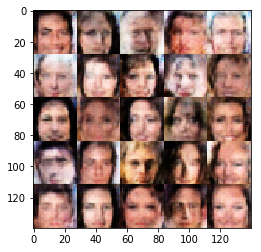

Epoches:  1/1 d_loss: 1.2751 g_loss: 1.0553
Epoches:  1/1 d_loss: 0.8746 g_loss: 1.1981
Epoches:  1/1 d_loss: 1.2753 g_loss: 0.6236
Epoches:  1/1 d_loss: 1.1924 g_loss: 0.9395
Epoches:  1/1 d_loss: 0.9219 g_loss: 1.4323
Epoches:  1/1 d_loss: 0.9134 g_loss: 1.3043
Epoches:  1/1 d_loss: 1.3941 g_loss: 1.6089
Epoches:  1/1 d_loss: 1.2195 g_loss: 0.7949
Epoches:  1/1 d_loss: 1.2947 g_loss: 0.7215
Epoches:  1/1 d_loss: 1.1737 g_loss: 0.7420


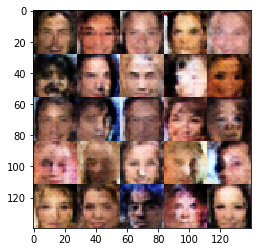

Epoches:  1/1 d_loss: 1.2640 g_loss: 0.8586
Epoches:  1/1 d_loss: 1.2719 g_loss: 1.1859
Epoches:  1/1 d_loss: 1.1624 g_loss: 0.8192
Epoches:  1/1 d_loss: 1.0056 g_loss: 0.9313
Epoches:  1/1 d_loss: 0.9169 g_loss: 1.3575
Epoches:  1/1 d_loss: 0.9968 g_loss: 1.2201
Epoches:  1/1 d_loss: 0.5601 g_loss: 2.1280
Epoches:  1/1 d_loss: 0.7723 g_loss: 1.6016
Epoches:  1/1 d_loss: 1.1982 g_loss: 0.9271
Epoches:  1/1 d_loss: 1.0948 g_loss: 0.9770


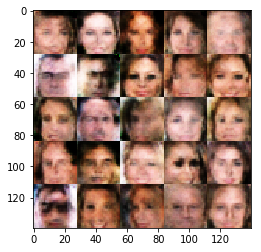

Epoches:  1/1 d_loss: 1.1701 g_loss: 0.8853
Epoches:  1/1 d_loss: 1.3516 g_loss: 0.8349
Epoches:  1/1 d_loss: 1.1822 g_loss: 0.8422
Epoches:  1/1 d_loss: 1.4749 g_loss: 1.8529
Epoches:  1/1 d_loss: 1.1276 g_loss: 1.0157
Epoches:  1/1 d_loss: 1.3204 g_loss: 0.6231
Epoches:  1/1 d_loss: 1.2981 g_loss: 0.7105
Epoches:  1/1 d_loss: 1.4367 g_loss: 0.6522
Epoches:  1/1 d_loss: 1.0997 g_loss: 0.8667
Epoches:  1/1 d_loss: 1.5310 g_loss: 1.2195


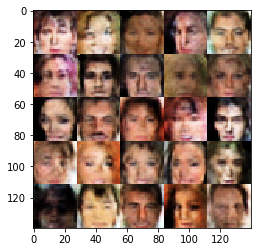

Epoches:  1/1 d_loss: 1.1252 g_loss: 1.2972
Epoches:  1/1 d_loss: 1.4883 g_loss: 1.0569
Epoches:  1/1 d_loss: 1.0137 g_loss: 1.3360
Epoches:  1/1 d_loss: 1.4579 g_loss: 1.7165
Epoches:  1/1 d_loss: 1.1374 g_loss: 1.3582
Epoches:  1/1 d_loss: 1.2876 g_loss: 0.6788
Epoches:  1/1 d_loss: 1.1465 g_loss: 0.8786
Epoches:  1/1 d_loss: 1.3281 g_loss: 0.5720
Epoches:  1/1 d_loss: 1.2515 g_loss: 1.3720
Epoches:  1/1 d_loss: 0.9844 g_loss: 1.1525


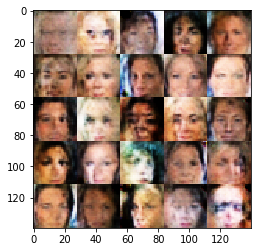

Epoches:  1/1 d_loss: 0.9990 g_loss: 1.0229
Epoches:  1/1 d_loss: 1.2918 g_loss: 1.2702
Epoches:  1/1 d_loss: 1.1776 g_loss: 1.0216
Epoches:  1/1 d_loss: 1.3012 g_loss: 0.9480
Epoches:  1/1 d_loss: 1.1582 g_loss: 0.8974
Epoches:  1/1 d_loss: 1.2007 g_loss: 1.0318
Epoches:  1/1 d_loss: 1.2026 g_loss: 0.7387
Epoches:  1/1 d_loss: 1.2705 g_loss: 0.7524
Epoches:  1/1 d_loss: 1.2282 g_loss: 0.8780
Epoches:  1/1 d_loss: 1.4783 g_loss: 0.4505


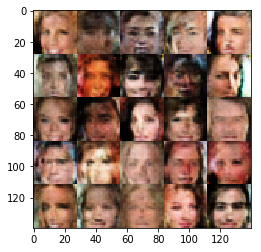

Epoches:  1/1 d_loss: 1.1536 g_loss: 1.0037
Epoches:  1/1 d_loss: 1.1694 g_loss: 1.1304
Epoches:  1/1 d_loss: 1.2832 g_loss: 0.5993
Epoches:  1/1 d_loss: 1.4718 g_loss: 0.7519
Epoches:  1/1 d_loss: 1.1084 g_loss: 0.9587
Epoches:  1/1 d_loss: 1.3342 g_loss: 1.9728
Epoches:  1/1 d_loss: 1.3236 g_loss: 0.6920
Epoches:  1/1 d_loss: 1.2665 g_loss: 0.8322
Epoches:  1/1 d_loss: 1.1443 g_loss: 1.5066
Epoches:  1/1 d_loss: 1.5911 g_loss: 0.4106


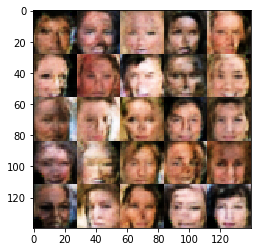

Epoches:  1/1 d_loss: 1.3469 g_loss: 0.7467
Epoches:  1/1 d_loss: 1.2191 g_loss: 0.8263
Epoches:  1/1 d_loss: 1.3678 g_loss: 0.6524
Epoches:  1/1 d_loss: 1.3002 g_loss: 0.7258
Epoches:  1/1 d_loss: 1.0839 g_loss: 1.0519
Epoches:  1/1 d_loss: 1.1358 g_loss: 0.9082
Epoches:  1/1 d_loss: 1.2192 g_loss: 0.7729
Epoches:  1/1 d_loss: 1.1222 g_loss: 1.3461
Epoches:  1/1 d_loss: 1.2423 g_loss: 0.9024
Epoches:  1/1 d_loss: 1.0195 g_loss: 1.0789


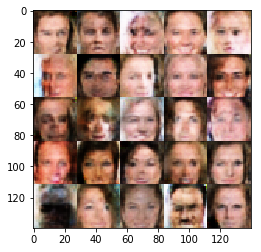

Epoches:  1/1 d_loss: 1.0389 g_loss: 1.7020
Epoches:  1/1 d_loss: 1.1091 g_loss: 1.7507
Epoches:  1/1 d_loss: 1.2087 g_loss: 0.9928
Epoches:  1/1 d_loss: 1.1448 g_loss: 0.9607
Epoches:  1/1 d_loss: 1.2507 g_loss: 0.6534
Epoches:  1/1 d_loss: 1.2496 g_loss: 1.3190
Epoches:  1/1 d_loss: 1.0946 g_loss: 1.2579
Epoches:  1/1 d_loss: 1.1879 g_loss: 0.8464
Epoches:  1/1 d_loss: 1.2501 g_loss: 0.9356
Epoches:  1/1 d_loss: 1.2504 g_loss: 0.6303


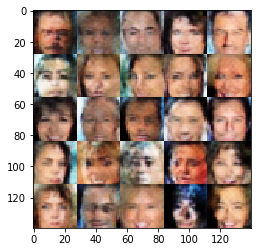

Epoches:  1/1 d_loss: 1.6398 g_loss: 0.4273
Epoches:  1/1 d_loss: 1.1825 g_loss: 0.7837
Epoches:  1/1 d_loss: 1.2829 g_loss: 0.6384
Epoches:  1/1 d_loss: 1.0287 g_loss: 1.0283
Epoches:  1/1 d_loss: 1.0497 g_loss: 0.8288
Epoches:  1/1 d_loss: 1.5595 g_loss: 0.4036
Epoches:  1/1 d_loss: 1.5277 g_loss: 0.5568
Epoches:  1/1 d_loss: 1.1296 g_loss: 0.9193
Epoches:  1/1 d_loss: 1.2023 g_loss: 0.7633
Epoches:  1/1 d_loss: 1.3943 g_loss: 0.6715


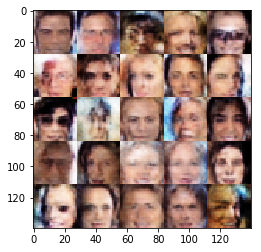

Epoches:  1/1 d_loss: 1.3291 g_loss: 0.7186
Epoches:  1/1 d_loss: 1.1921 g_loss: 0.6310
Epoches:  1/1 d_loss: 1.2356 g_loss: 0.7795
Epoches:  1/1 d_loss: 1.2561 g_loss: 0.8907
Epoches:  1/1 d_loss: 1.4485 g_loss: 0.5122
Epoches:  1/1 d_loss: 1.2230 g_loss: 0.8090
Epoches:  1/1 d_loss: 1.2431 g_loss: 0.7577
Epoches:  1/1 d_loss: 1.1802 g_loss: 0.9325
Epoches:  1/1 d_loss: 1.1875 g_loss: 0.9067
Epoches:  1/1 d_loss: 1.0837 g_loss: 1.1030


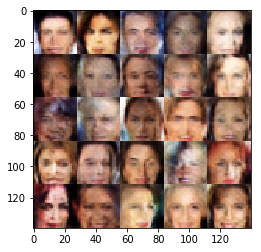

Epoches:  1/1 d_loss: 1.3578 g_loss: 0.5552
Epoches:  1/1 d_loss: 1.2116 g_loss: 0.9081
Epoches:  1/1 d_loss: 1.2590 g_loss: 0.8199
Epoches:  1/1 d_loss: 1.2538 g_loss: 0.8653
Epoches:  1/1 d_loss: 1.3709 g_loss: 0.8520
Epoches:  1/1 d_loss: 1.1960 g_loss: 0.8195
Epoches:  1/1 d_loss: 1.1742 g_loss: 0.9600
Epoches:  1/1 d_loss: 1.4981 g_loss: 0.5907
Epoches:  1/1 d_loss: 1.1830 g_loss: 0.8438
Epoches:  1/1 d_loss: 1.2363 g_loss: 1.5064


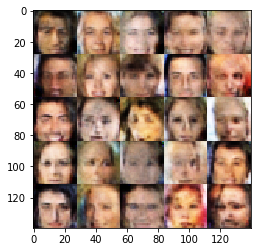

Epoches:  1/1 d_loss: 1.2893 g_loss: 0.9335
Epoches:  1/1 d_loss: 1.2832 g_loss: 0.6936
Epoches:  1/1 d_loss: 1.2816 g_loss: 0.6023
Epoches:  1/1 d_loss: 1.0828 g_loss: 1.0083
Epoches:  1/1 d_loss: 1.1642 g_loss: 1.2423
Epoches:  1/1 d_loss: 1.3064 g_loss: 1.1383
Epoches:  1/1 d_loss: 1.3990 g_loss: 0.8201
Epoches:  1/1 d_loss: 1.1831 g_loss: 0.7525
Epoches:  1/1 d_loss: 1.1249 g_loss: 0.9808
Epoches:  1/1 d_loss: 1.3232 g_loss: 0.9840


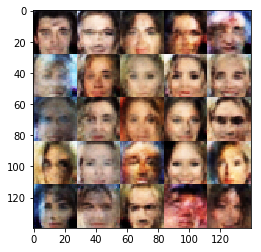

Epoches:  1/1 d_loss: 1.3114 g_loss: 0.6998
Epoches:  1/1 d_loss: 1.5470 g_loss: 0.5656
Epoches:  1/1 d_loss: 1.2535 g_loss: 1.0606
Epoches:  1/1 d_loss: 0.9905 g_loss: 1.0390
Epoches:  1/1 d_loss: 1.2094 g_loss: 0.7562
Epoches:  1/1 d_loss: 1.4345 g_loss: 0.6288
Epoches:  1/1 d_loss: 1.4605 g_loss: 0.6066
Epoches:  1/1 d_loss: 1.5093 g_loss: 0.4856
Epoches:  1/1 d_loss: 1.1375 g_loss: 1.0809
Epoches:  1/1 d_loss: 1.0812 g_loss: 1.0005


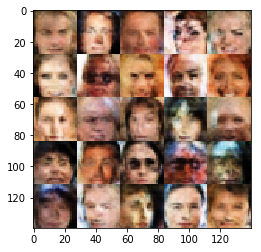

Epoches:  1/1 d_loss: 1.2234 g_loss: 0.7098
Epoches:  1/1 d_loss: 1.1280 g_loss: 0.9707
Epoches:  1/1 d_loss: 1.2530 g_loss: 1.3396
Epoches:  1/1 d_loss: 1.3494 g_loss: 0.6342
Epoches:  1/1 d_loss: 1.2222 g_loss: 0.8706
Epoches:  1/1 d_loss: 1.2676 g_loss: 0.7610
Epoches:  1/1 d_loss: 1.4540 g_loss: 0.6591
Epoches:  1/1 d_loss: 1.1398 g_loss: 0.9054
Epoches:  1/1 d_loss: 1.3069 g_loss: 1.4046
Epoches:  1/1 d_loss: 1.1784 g_loss: 1.0235


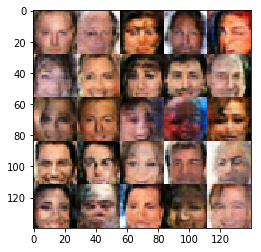

Epoches:  1/1 d_loss: 1.4670 g_loss: 1.2082
Epoches:  1/1 d_loss: 1.3043 g_loss: 0.6784
Epoches:  1/1 d_loss: 1.2042 g_loss: 0.8525
Epoches:  1/1 d_loss: 1.1757 g_loss: 0.9036
Epoches:  1/1 d_loss: 1.3618 g_loss: 0.5905
Epoches:  1/1 d_loss: 1.2526 g_loss: 0.8782
Epoches:  1/1 d_loss: 1.3694 g_loss: 0.9000
Epoches:  1/1 d_loss: 1.1121 g_loss: 1.0759
Epoches:  1/1 d_loss: 1.2116 g_loss: 1.0155
Epoches:  1/1 d_loss: 1.1882 g_loss: 1.4465


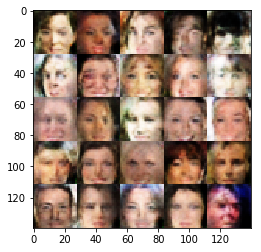

Epoches:  1/1 d_loss: 1.3529 g_loss: 1.2492
Epoches:  1/1 d_loss: 1.3536 g_loss: 0.8178
Epoches:  1/1 d_loss: 1.4207 g_loss: 0.6606
Epoches:  1/1 d_loss: 1.2935 g_loss: 0.6860
Epoches:  1/1 d_loss: 1.2112 g_loss: 0.8097
Epoches:  1/1 d_loss: 1.3737 g_loss: 0.8032
Epoches:  1/1 d_loss: 1.3553 g_loss: 1.0843
Epoches:  1/1 d_loss: 1.0747 g_loss: 1.0103
Epoches:  1/1 d_loss: 1.1986 g_loss: 0.7183
Epoches:  1/1 d_loss: 1.1178 g_loss: 0.8169


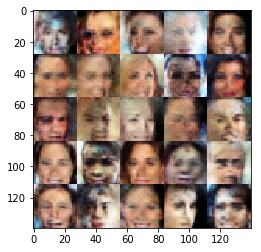

Epoches:  1/1 d_loss: 1.2663 g_loss: 1.1207
Epoches:  1/1 d_loss: 1.1552 g_loss: 0.8766
Epoches:  1/1 d_loss: 1.1809 g_loss: 1.0772
Epoches:  1/1 d_loss: 1.3869 g_loss: 0.6643
Epoches:  1/1 d_loss: 1.1768 g_loss: 0.8649
Epoches:  1/1 d_loss: 1.3518 g_loss: 0.6838
Epoches:  1/1 d_loss: 1.2449 g_loss: 0.7757
Epoches:  1/1 d_loss: 1.2803 g_loss: 0.5742
Epoches:  1/1 d_loss: 1.3495 g_loss: 0.7346
Epoches:  1/1 d_loss: 1.0792 g_loss: 1.0462


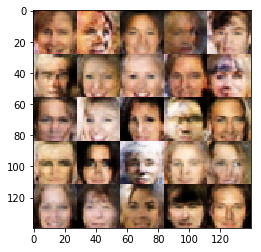

Epoches:  1/1 d_loss: 1.2481 g_loss: 0.6534
Epoches:  1/1 d_loss: 1.1614 g_loss: 1.0159
Epoches:  1/1 d_loss: 1.2811 g_loss: 0.7801
Epoches:  1/1 d_loss: 1.2908 g_loss: 0.6960
Epoches:  1/1 d_loss: 1.3627 g_loss: 0.6643
Epoches:  1/1 d_loss: 1.1861 g_loss: 0.8206
Epoches:  1/1 d_loss: 1.2888 g_loss: 0.6607
Epoches:  1/1 d_loss: 1.3277 g_loss: 0.7236
Epoches:  1/1 d_loss: 1.3910 g_loss: 0.7139
Epoches:  1/1 d_loss: 1.3422 g_loss: 1.2174


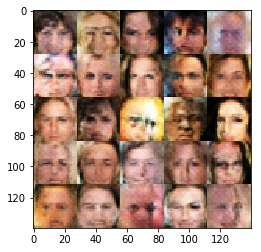

Epoches:  1/1 d_loss: 1.0043 g_loss: 1.1992
Epoches:  1/1 d_loss: 1.0853 g_loss: 0.8283
Epoches:  1/1 d_loss: 1.2261 g_loss: 1.0159
Epoches:  1/1 d_loss: 1.1601 g_loss: 0.7083
Epoches:  1/1 d_loss: 1.2064 g_loss: 0.8350
Epoches:  1/1 d_loss: 1.3433 g_loss: 0.5462
Epoches:  1/1 d_loss: 0.7597 g_loss: 2.3246
Epoches:  1/1 d_loss: 1.2127 g_loss: 1.0904
Epoches:  1/1 d_loss: 1.2320 g_loss: 1.1677
Epoches:  1/1 d_loss: 1.2260 g_loss: 0.7478


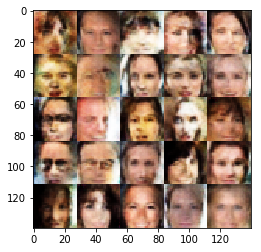

Epoches:  1/1 d_loss: 1.3425 g_loss: 0.8332
Epoches:  1/1 d_loss: 1.1047 g_loss: 1.3184
Epoches:  1/1 d_loss: 1.3726 g_loss: 0.5627
Epoches:  1/1 d_loss: 1.3718 g_loss: 0.8819
Epoches:  1/1 d_loss: 1.1734 g_loss: 0.8713
Epoches:  1/1 d_loss: 1.2963 g_loss: 0.7186
Epoches:  1/1 d_loss: 1.2365 g_loss: 1.0868
Epoches:  1/1 d_loss: 1.4036 g_loss: 0.5143
Epoches:  1/1 d_loss: 1.3147 g_loss: 0.8102
Epoches:  1/1 d_loss: 1.2089 g_loss: 0.7518


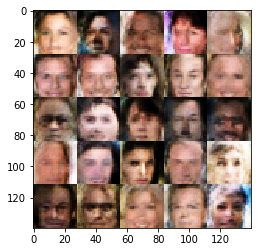

Epoches:  1/1 d_loss: 1.0668 g_loss: 1.1182
Epoches:  1/1 d_loss: 1.2512 g_loss: 1.0820
Epoches:  1/1 d_loss: 1.2860 g_loss: 0.8630
Epoches:  1/1 d_loss: 1.2321 g_loss: 1.0224
Epoches:  1/1 d_loss: 1.0366 g_loss: 0.9790
Epoches:  1/1 d_loss: 1.0981 g_loss: 1.0525
Epoches:  1/1 d_loss: 1.1367 g_loss: 0.8540
Epoches:  1/1 d_loss: 1.2711 g_loss: 0.8667
Epoches:  1/1 d_loss: 1.3330 g_loss: 0.9136
Epoches:  1/1 d_loss: 1.3189 g_loss: 0.7176


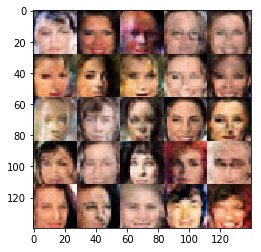

Epoches:  1/1 d_loss: 1.1694 g_loss: 0.9075
Epoches:  1/1 d_loss: 1.2839 g_loss: 0.7483
Epoches:  1/1 d_loss: 1.0672 g_loss: 0.8893
Epoches:  1/1 d_loss: 1.4028 g_loss: 0.7178
Epoches:  1/1 d_loss: 1.2146 g_loss: 0.7957
Epoches:  1/1 d_loss: 1.2559 g_loss: 0.7516
Epoches:  1/1 d_loss: 1.2914 g_loss: 0.7644
Epoches:  1/1 d_loss: 1.3042 g_loss: 0.7115
Epoches:  1/1 d_loss: 1.3182 g_loss: 0.7335
Epoches:  1/1 d_loss: 1.6771 g_loss: 0.3457


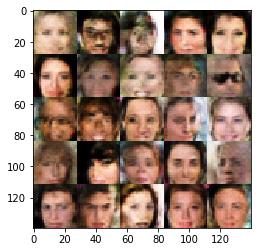

Epoches:  1/1 d_loss: 1.2898 g_loss: 0.7198
Epoches:  1/1 d_loss: 1.1838 g_loss: 1.2342
Epoches:  1/1 d_loss: 1.3083 g_loss: 0.8588
Epoches:  1/1 d_loss: 1.3981 g_loss: 0.5255
Epoches:  1/1 d_loss: 1.1265 g_loss: 0.8652
Epoches:  1/1 d_loss: 1.2758 g_loss: 0.6537
Epoches:  1/1 d_loss: 1.1066 g_loss: 0.9182
Epoches:  1/1 d_loss: 1.1137 g_loss: 0.9466
Epoches:  1/1 d_loss: 1.5871 g_loss: 0.3816
Epoches:  1/1 d_loss: 1.3072 g_loss: 0.6975


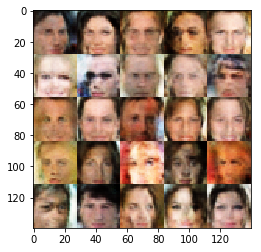

Epoches:  1/1 d_loss: 1.0878 g_loss: 1.0545
Epoches:  1/1 d_loss: 1.3948 g_loss: 0.6764
Epoches:  1/1 d_loss: 1.2663 g_loss: 0.8365
Epoches:  1/1 d_loss: 1.1183 g_loss: 1.1321
Epoches:  1/1 d_loss: 1.3642 g_loss: 0.6028
Epoches:  1/1 d_loss: 1.0782 g_loss: 0.9455
Epoches:  1/1 d_loss: 1.4624 g_loss: 0.5434
Epoches:  1/1 d_loss: 1.2428 g_loss: 0.7251
Epoches:  1/1 d_loss: 1.2580 g_loss: 1.1691
Epoches:  1/1 d_loss: 1.3337 g_loss: 0.6552


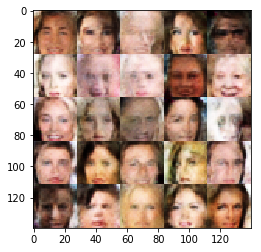

Epoches:  1/1 d_loss: 1.3845 g_loss: 0.5728
Epoches:  1/1 d_loss: 1.2186 g_loss: 0.7854
Epoches:  1/1 d_loss: 1.2538 g_loss: 1.0578
Epoches:  1/1 d_loss: 1.1533 g_loss: 0.8060
Epoches:  1/1 d_loss: 1.2253 g_loss: 0.7929
Epoches:  1/1 d_loss: 1.1192 g_loss: 0.8377
Epoches:  1/1 d_loss: 1.1525 g_loss: 0.7822
Epoches:  1/1 d_loss: 1.5756 g_loss: 0.4147
Epoches:  1/1 d_loss: 1.2476 g_loss: 0.8151
Epoches:  1/1 d_loss: 1.2864 g_loss: 0.8338


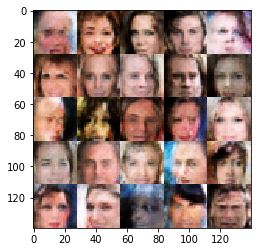

Epoches:  1/1 d_loss: 1.2455 g_loss: 0.6694
Epoches:  1/1 d_loss: 1.3261 g_loss: 0.7224
Epoches:  1/1 d_loss: 1.3271 g_loss: 0.7168
Epoches:  1/1 d_loss: 1.1864 g_loss: 1.2058
Epoches:  1/1 d_loss: 1.3894 g_loss: 1.0989
Epoches:  1/1 d_loss: 1.1915 g_loss: 0.7478
Epoches:  1/1 d_loss: 1.1634 g_loss: 1.2346
Epoches:  1/1 d_loss: 1.4440 g_loss: 0.7527
Epoches:  1/1 d_loss: 1.3448 g_loss: 0.6381
Epoches:  1/1 d_loss: 1.2315 g_loss: 0.8728


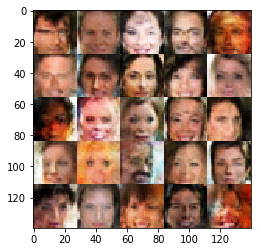

Epoches:  1/1 d_loss: 1.2271 g_loss: 0.7200
Epoches:  1/1 d_loss: 1.2604 g_loss: 0.7436
Epoches:  1/1 d_loss: 1.5627 g_loss: 0.4685


In [32]:
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.